# Clustering Anomaly Detection

## Exercises

### Ideas:
* Use DBSCAN to detect anomalies in curriculumn access.
* Use DBSCAN to detect anomalies in other products from the customers dataset.
* Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

## Anomaly Dectection In Access Logs

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

import functions

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
logs = functions.wrangle_access_logs()

In [3]:
# Lets look for outliers when looking at total number of pages, and unqiue count of pages

page_views = logs.groupby(["user_id"]).destination.agg(["count", "nunique"])

In [4]:
scaler = MinMaxScaler().fit(page_views)
page_views_scaled_array = scaler.transform(page_views)

In [5]:
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(page_views_scaled_array)

In [6]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(page_views.columns)
scaled_columns = ["scaled_" + column for column in columns]
scaled_columns

['scaled_count', 'scaled_nunique']

In [7]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(page_views_scaled_array, columns=scaled_columns)
scaled_df

,scaled_count,scaled_nunique
0,0.491323,1.000000
1,0.139190,0.183374
2,0.141088,0.205379
3,0.062455,0.173594
4,0.153651,0.239609
...,...,...
645,0.003615,0.026895
646,0.000813,0.006112
647,0.044017,0.157702
648,0.000000,0.000000


In [8]:
# Merge the scaled and non-scaled values into one dataframe
page_views = page_views.merge(scaled_df, on=page_views.index)
page_views

,key_0,count,nunique,scaled_count,scaled_nunique
0,1,5437,819,0.491323,1.000000
1,2,1541,151,0.139190,0.183374
2,3,1562,169,0.141088,0.205379
3,4,692,143,0.062455,0.173594
4,5,1701,197,0.153651,0.239609
...,...,...,...,...,...
645,646,41,23,0.003615,0.026895
646,647,10,6,0.000813,0.006112
647,648,488,130,0.044017,0.157702
648,649,1,1,0.000000,0.000000


In [9]:
page_views = page_views.drop(columns=['key_0'])
page_views.head()

,count,nunique,scaled_count,scaled_nunique
0,5437,819,0.491323,1.000000
1,1541,151,0.139190,0.183374
2,1562,169,0.141088,0.205379
3,692,143,0.062455,0.173594
4,1701,197,0.153651,0.239609


Now we can look at our labels

In [10]:
labels = dbsc.labels_
labels[0:10]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [11]:
page_views['labels'] = labels
page_views.labels.value_counts()

 0    642
-1      8
Name: labels, dtype: int64

In [12]:
page_views[page_views.labels==-1]

,count,nunique,scaled_count,scaled_nunique,labels
0,5437,819,0.491323,1.000000,-1
10,11065,698,1.000000,0.852078,-1
52,9534,303,0.861623,0.369193,-1
63,10784,373,0.974602,0.454768,-1
247,2815,456,0.254338,0.556235,-1
313,4695,181,0.424259,0.220049,-1
343,5370,215,0.485268,0.261614,-1
403,1668,352,0.150669,0.429095,-1


In [13]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(page_views.describe())
print("-------------")
print("Inliers")
print(page_views[page_views.labels==0].describe())
print("-------------")
print("Outliers")
print(page_views[page_views.labels==-1].describe())

Population
              count     nunique  scaled_count  scaled_nunique      labels
count    650.000000  650.000000    650.000000      650.000000  650.000000
mean     836.300000  116.961538      0.075497        0.141762   -0.012308
std      984.091716   76.488698      0.088945        0.093507    0.110340
min        1.000000    1.000000      0.000000        0.000000   -1.000000
25%      178.000000   58.000000      0.015998        0.069682    0.000000
50%      677.500000  137.500000      0.061144        0.166870    0.000000
75%     1159.000000  159.000000      0.104664        0.193154    0.000000
max    11065.000000  819.000000      1.000000        1.000000    0.000000
-------------
Inliers
             count     nunique  scaled_count  scaled_nunique  labels
count   642.000000  642.000000    642.000000      642.000000   642.0
mean    766.708723  113.127726      0.069207        0.137075     0.0
std     666.744807   64.576135      0.060263        0.078944     0.0
min       1.000000    1.0

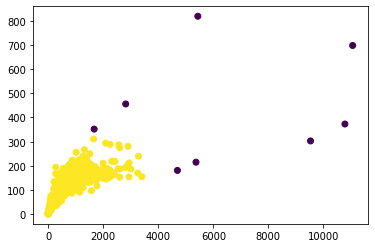

In [14]:
plt.scatter(page_views['count'], page_views['nunique'], c=page_views.labels)
plt.show()

### Can we see if there are any cohorts that look at pages more than the rest?

In [15]:
view_by_cohort = logs.groupby("cohort").destination.agg(["count", "nunique"])

# Need to scale the data
scaler = MinMaxScaler().fit(view_by_cohort)
cohort_views_scaled_array = scaler.transform(view_by_cohort)

# Now we model
dbsc = DBSCAN(eps = .5, min_samples = 20).fit(cohort_views_scaled_array)

scaled_data = pd.DataFrame(cohort_views_scaled_array, columns=["count_scaled", "nunique_scaled"])

view_by_cohort = view_by_cohort.reset_index()

df = pd.concat([view_by_cohort, scaled_data], axis = 1)

df["labels"] = labels

Text(0.5, 1.0, 'Do page visit vary by cohort?')

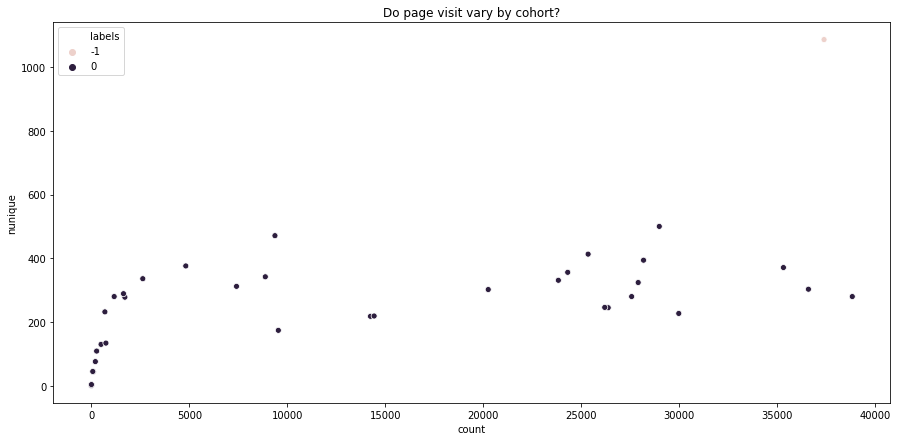

In [35]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df, x="count", y="nunique", hue="labels")
plt.title("Do page visit vary by cohort?")

In [28]:
# Most likely I have identified the instructors
df[df.labels == -1]

,cohort,count,nunique,count_scaled,nunique_scaled,labels
24,28.0,37409,1086,0.962883,1.0,-1


### Can we find out cohorts that are newer based on clusters?

In [150]:
logs = functions.wrangle_access_logs()

view_by_cohort = logs.groupby("cohort").destination.agg(["count", "nunique"])

# Need to scale the data
scaler = MinMaxScaler().fit(view_by_cohort)
cohort_views_scaled_array = scaler.transform(view_by_cohort)

# Now we model
dbsc = DBSCAN(eps = .2, min_samples = 10).fit(cohort_views_scaled_array)

scaled_data = pd.DataFrame(cohort_views_scaled_array, columns=["count_scaled", "nunique_scaled"])


view_by_cohort = view_by_cohort.reset_index()

df = pd.concat([view_by_cohort, scaled_data], axis = 1)

labels = dbsc.labels_

df["labels"] = labels

Text(0.5, 1.0, 'Do page visit vary by cohort?')

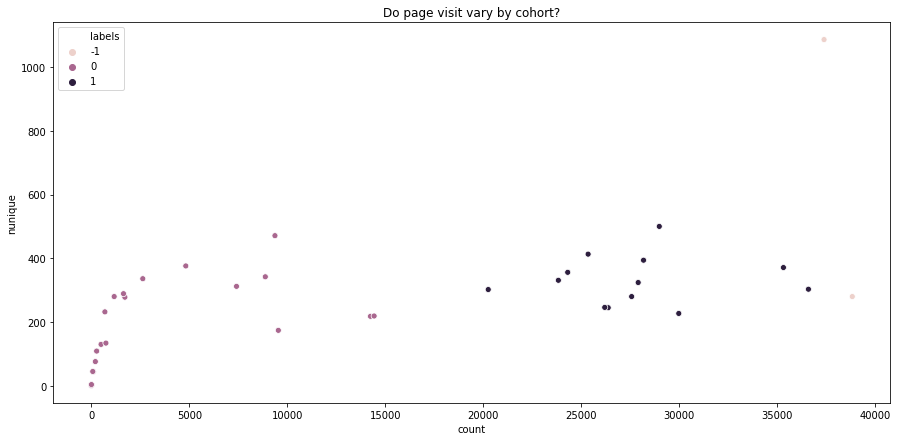

In [162]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df, x="count", y="nunique", hue="labels")
plt.title("Do page visit vary by cohort?")

In [166]:
# Most likely the instructor cohorts
df[df.labels == -1]

,cohort,count,nunique,count_scaled,nunique_scaled,labels
24,28.0,37409,1086,0.962883,1.000000,-1
28,33.0,38851,280,1.000000,0.257143,-1


In [167]:
# Most likely the newer cohorts
df[df.labels == 0]

,cohort,count,nunique,count_scaled,nunique_scaled,labels
0,1.0,8882,342,0.228597,0.314286,0
1,2.0,93,44,0.002368,0.039631,0
2,4.0,4,4,0.000077,0.002765,0
3,5.0,1,1,0.000000,0.000000,0
4,6.0,72,45,0.001828,0.040553,0
5,7.0,495,130,0.012716,0.118894,0
6,8.0,1712,278,0.044041,0.255300,0
7,9.0,5,4,0.000103,0.002765,0
8,11.0,204,76,0.005225,0.069124,0
9,12.0,270,109,0.006924,0.099539,0


In [169]:
# Most likely the older cohorts
df[df.labels == 1]

,cohort,count,nunique,count_scaled,nunique_scaled,labels
18,22.0,28997,500,0.746358,0.459908,1
19,23.0,28193,394,0.725663,0.362212,1
20,24.0,35336,371,0.909524,0.341014,1
21,25.0,25364,413,0.652844,0.379724,1
22,26.0,27586,280,0.710039,0.257143,1
23,27.0,20264,302,0.521570,0.277419,1
25,29.0,36613,303,0.942394,0.278341,1
26,31.0,24322,356,0.626023,0.327189,1
27,32.0,27920,324,0.718636,0.297696,1
29,34.0,23845,331,0.613745,0.304147,1


Overall - I don't think that we can use clustering to find the newer versus older cohorts, simply because there are a couple of outliers. For example, there are some cohorts that have very little users, which also have small access to the pages.

### Are there any anomalies in the number of pages visited in data science students?

In [194]:
logs = functions.wrangle_access_logs()

In [195]:
ds = logs[(logs.is_wd == 0) & (logs.is_ds == 1)]

In [196]:
ds_students = ds.groupby("user_id").destination.agg(["count", "nunique"])

In [197]:
# Need to scale the data
scaler = MinMaxScaler().fit(ds_students)
user_views_scaled_array = scaler.transform(ds_students)

In [198]:
# Now we model
dbsc = DBSCAN(eps = .2, min_samples = 10).fit(user_views_scaled_array)

scaled_data = pd.DataFrame(user_views_scaled_array, columns=["count_scaled", "nunique_scaled"])

In [200]:
ds_students = ds_students.reset_index()

In [201]:
ds_students.shape, scaled_data.shape

((54, 4), (54, 2))

In [203]:
df = pd.concat([ds_students, scaled_data], axis = 1)

In [204]:
labels = dbsc.labels_

In [205]:
df["labels"] = labels

Text(0.5, 1.0, 'Do page visit vary by data science students vary grately?')

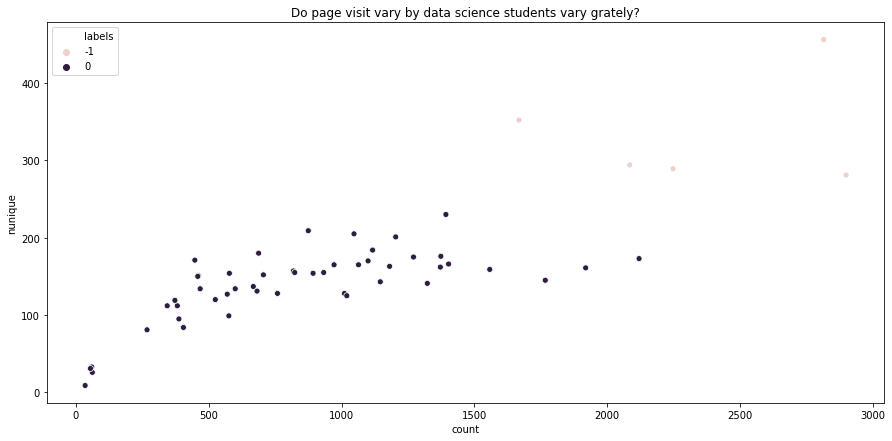

In [207]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df, x="count", y="nunique", hue="labels")
plt.title("Do page visit vary by data science students vary grately?")

In [208]:
df[df.labels == -1]

,index,user_id,count,nunique,count_scaled,nunique_scaled,labels
2,2,248,2815,456,0.970670,1.000000,-1
5,5,354,2899,281,1.000000,0.608501,-1
7,7,363,2248,289,0.772696,0.626398,-1
9,9,368,2085,294,0.715782,0.637584,-1
12,12,404,1668,352,0.570182,0.767338,-1


It doesn't look like we have a lot of instructors in the outlier group!